<a href="https://colab.research.google.com/github/ryanraba/casa6/blob/master/CASA_imageclassifier_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install imgpy > /dev/null
import urllib.request

urllib.request.urlretrieve("https://www.cv.nrao.edu/~rraba/Examples.GOOD.gif", "Examples.GOOD.gif")
urllib.request.urlretrieve("https://www.cv.nrao.edu/~rraba/Examples.BOTH.gif", "Examples.BOTH.gif")
urllib.request.urlretrieve("https://www.cv.nrao.edu/~rraba/Examples.TYPE1.gif", "Examples.TYPE1.gif")
urllib.request.urlretrieve("https://www.cv.nrao.edu/~rraba/Examples.TYPE2.gif", "Examples.TYPE2.gif");

# Data Preparation
Reads in data and preps for training.  This will set things up for both binary classification and categorical classification.

It's nice to have roughly balanced sample counts for each class so the model has to work harder to distinguish each.  Here we see that each of the three types of ARTIFACTS have roughly the same count, so that's good, but there are significantly more GOOD examples.  So we will truncate the GOOD examples to equal the total count of ARTIFACT examples.  This will be balanced for binary classification but overweight on GOOD samples for categorical classification.

We will also use a utility to randomly alter each sample image for each training epoch.  This will give the appearance of having more data than we really do and help the model to generalize better (avoid overfitting)

In [19]:
import PIL
import numpy as np
import imgpy
import matplotlib.pyplot as plt
from keras.utils import to_categorical
np.random.seed(17)

# because the axes are in the image
crop_box = (171, 60, 651, 540)

# convert from raw image format to a numpy data matrix
# downsample a bit for speed (we're in a free cloud environment here)
# build targets vector as we go (truth)
images = imgpy.Img(fp='Examples.BOTH.gif').frames
dm = np.array([np.array(dv.crop(crop_box).resize(size=(408,304), resample=PIL.Image.BILINEAR)) for dv in images])
targets = np.zeros((len(images)))  # both kinds of bad are a 0
print('BOTH count',len(images))

images = imgpy.Img(fp='Examples.TYPE1.gif').frames
dm = np.concatenate((dm, np.array([np.array(dv.crop(crop_box).resize(size=(408,304), resample=PIL.Image.BILINEAR)) for dv in images])), axis=0)
targets = np.concatenate((targets, np.zeros((len(images)))+1), axis=0)  # type1 bad is a 1
print('TYPE1 count',len(images))

images = imgpy.Img(fp='Examples.TYPE2.gif').frames
dm = np.concatenate((dm, np.array([np.array(dv.crop(crop_box).resize(size=(408,304), resample=PIL.Image.BILINEAR)) for dv in images])), axis=0)
targets = np.concatenate((targets, np.zeros((len(images)))+2), axis=0)  # type2 bad is a 2
print('TYPE2 count',len(images))

images = imgpy.Img(fp='Examples.GOOD.gif').frames
dm = np.concatenate((dm, np.array([np.array(dv.crop(crop_box).resize(size=(408,304), resample=PIL.Image.BILINEAR)) for dv in images])), axis=0)
targets = np.concatenate((targets, np.zeros((len(images)))+3), axis=0)  # lets say GOOD images are a 3
print('GOOD count', len(images))

# normalize to 1
dm = dm[..., np.newaxis]/255.0

# save categorical targets for later, let's start with binary classification for now
categories = to_categorical(targets, num_classes=4) # one-hot encoding
targets[targets < 3] = 0
targets[targets == 3] = 1

# lets balance the bad with the good so it's 50/50
# this makes the model accuracy more meaningful
bcnt = len(np.where(targets == 0)[0])
dm = dm[:2*bcnt]
targets = targets[:2*bcnt]
categories = categories[:2*bcnt]
print('combined count', len(dm))

BOTH count 168
TYPE1 count 153
TYPE2 count 157
GOOD count 803
combined count 956


In [5]:
# randomly divide data in to training, validation, and test sets
# model is trained with train and validated with val
# test is saved for later as an independent holdout
np.random.seed(42)
train = np.random.choice(range(len(dm)), int(0.7*len(dm)), replace=False)
val = np.random.choice(np.setdiff1d(range(len(dm)), train), int(0.15*len(dm)), replace=False)
test = np.random.choice(np.setdiff1d(range(len(dm)), np.hstack((train, val))), int(0.15*len(dm)), replace=False)
print(len(dm), len(train), len(val), len(test))

956 669 143 143


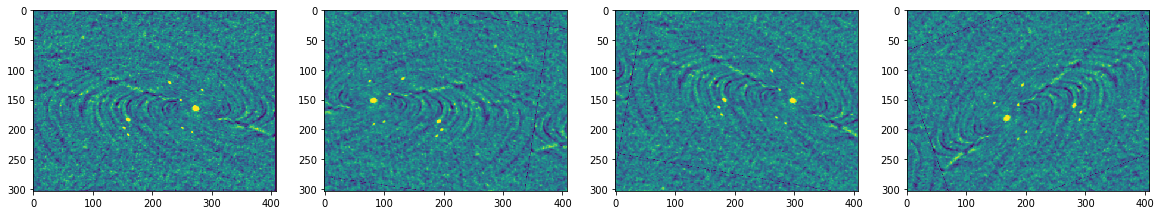

In [6]:
# because there are only ~1k samples, models are going to overfit and be super sensitive to val/test splits
# heres a neat trick where we can augment our training data by randomly moving it around
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             fill_mode='wrap')

datagen.fit(dm)

# observe, same training image four different ways
ff, aa = plt.subplots(1,4, figsize=(20,20))
aa[0].imshow(dm[train[0]][:,:,0])
aa[1].imshow(datagen.random_transform(dm[train[0]], seed=17)[:,:,0])
aa[2].imshow(datagen.random_transform(dm[train[0]], seed=138)[:,:,0])
aa[3].imshow(datagen.random_transform(dm[train[0]], seed=1989)[:,:,0]);

# Binary Classification of GOOD versus ARTIFACT images
This model currently achieves nearly 90% accuracy, but it's a stochastic process and depending on the initial tensor weights, some trainings go better than others.  So it may be wise to run it a few times.

Since the model seems to get stuck and plateau without overfitting, let's try reducing the learning rate of the optimizer when the plateau hits.

In [0]:
# here we build and train a CNN model
# lots of ways to do it, try different sizes, depths, activations, regularizations etc
# the loss/acc slope may be rocky, especially with lots of regularization/dropout
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, SpatialDropout2D
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

ins = Input(shape=(dm.shape[1], dm.shape[2], 1))
hh = Conv2D(32, (2, 2), activation='relu', padding='same')(ins)
hh = MaxPooling2D(pool_size=2, strides=2, padding='same')(hh)
hh = Conv2D(16, (2, 2), activation='relu', padding='same')(hh)
hh = MaxPooling2D(pool_size=2, strides=2, padding='same')(hh)
hh = Conv2D(16, (2, 2), activation='relu', padding='same')(hh)
hh = MaxPooling2D(pool_size=2, strides=2, padding='same')(hh)
hh = Flatten()(hh)
hh = Dense(32, activation='tanh')(hh)
outs = Dense(1, activation='sigmoid')(hh)

classifier = Model(ins, outs)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# fit the model using the straight training data
#classifier.fit(dm[train], targets[train], epochs=1000, batch_size=32, shuffle=True, verbose=1,
#               validation_data=(dm[val], targets[val]),
#               callbacks=[ModelCheckpoint('cnn_model.h5','val_acc',0, True, False),
#                          EarlyStopping(monitor='val_loss', patience=6)])

# or
# fit the model using augmented training data, have more patience as it will be rockier
classifier.fit_generator(datagen.flow(dm[train], targets[train], batch_size=32),
                         steps_per_epoch=len(train) / 32, epochs=1000,
                         validation_data=datagen.flow(dm[val], targets[val], batch_size=32), validation_steps=len(val)/32, #(dm[val], targets[val]),
                         callbacks=[ModelCheckpoint('cnn_model.h5','val_loss',0, True, False),
                                    EarlyStopping(monitor='val_loss', patience=26),
                                    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1)])

# trains for many epochs so we'll remove the output for bevity

classifier accuracy on train set 0.8953662182361734
classifier accuracy on val set 0.9020979020979021
classifier accuracy on test set 0.8811188811188811


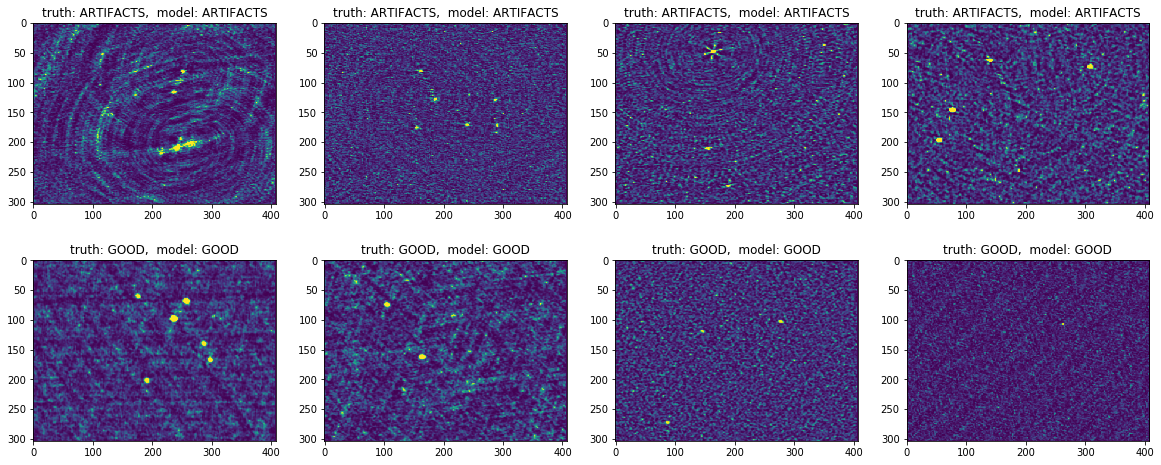

In [44]:
from matplotlib import colors
from sklearn.metrics import accuracy_score

# load best model saved during training
classifier = load_model('cnn_model.h5')

# just for kicks, lets verify training and validation accuracy first
preds = np.round(classifier.predict(dm[train]))
print('classifier accuracy on train set', accuracy_score(targets[train], preds))

preds = np.round(classifier.predict(dm[val]))
print('classifier accuracy on val set', accuracy_score(targets[val], preds))

# now the interesting part, lets see what the accuracy is on new data
preds = np.round(classifier.predict(dm[test]))
print('classifier accuracy on test set', accuracy_score(targets[test], preds))

# spot check some stuff
ff, aa = plt.subplots(2,4, figsize=(20,8))
labels = ['ARTIFACTS','GOOD']
samples = np.where(targets[test] == 0)[0][:4]
for ii,ss in enumerate(samples):
  aa[0,ii].imshow(dm[test[ss]][:,:,0], norm=colors.PowerNorm(3))
  aa[0,ii].set_title('truth: ARTIFACTS,  model: ' + labels[int(preds[ss][0])])

samples = np.where(targets[test] == 1)[0][:4]
for ii,ss in enumerate(samples):
  aa[1,ii].imshow(dm[test[ss]][:,:,0], norm=colors.PowerNorm(3))
  aa[1,ii].set_title('truth: GOOD,  model: ' + labels[int(preds[ss][0])])

# Categorical Classification
Here we use categories of GOOD, TYPE1, TYPE2, and BOTH for a total of four possible answers.  Since GOOD is over-represented in the training data, we will weight our classes accordingly so the model pays more attention to the under-represented samples.

The model currently achieves about 70% accuracy overall against the four categories.  Some categories do better than others.

As a next step, it would be interesting to keep the prediction probabilities (dont round) and see if the instances of miscategorization correspond to lower prediction probability.

In [0]:
# now lets try categorical classification
# same-ish model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, SpatialDropout2D
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_sample_weight

# we will weight each sample inversely to the frequency of its class in the training data
sample_weights = compute_sample_weight('balanced', np.argmax(categories, axis=1))

ins = Input(shape=(dm.shape[1], dm.shape[2], 1))
hh = Conv2D(32, (2, 2), activation='relu', padding='same')(ins)
hh = MaxPooling2D(pool_size=2, strides=2, padding='same')(hh)
hh = Conv2D(16, (2, 2), activation='relu', padding='same')(hh)
hh = MaxPooling2D(pool_size=2, strides=2, padding='same')(hh)
hh = Conv2D(16, (2, 2), activation='relu', padding='same')(hh)
hh = MaxPooling2D(pool_size=2, strides=2, padding='same')(hh)
hh = Flatten()(hh)
hh = Dense(32, activation='tanh')(hh)
outs = Dense(4, activation='softmax')(hh)

classifier = Model(ins, outs)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

classifier.fit_generator(datagen.flow(dm[train], categories[train], batch_size=32, sample_weight=sample_weights[train]),
                         steps_per_epoch=len(train) / 32, epochs=1000,
                         validation_data=datagen.flow(dm[val], categories[val], batch_size=32, sample_weight=sample_weights[val]), 
                         validation_steps=len(val)/32,
                         callbacks=[ModelCheckpoint('cnn_model2.h5','val_loss',0, True, False),
                                    EarlyStopping(monitor='val_loss', patience=26),
                                    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1)])


classifier accuracy on train set 0.7339312406576981
weighted train accuracy 0.7169362033368621

classifier accuracy on val set 0.6993006993006993
weighted val accuracy 0.6939384628087689

classifier accuracy on test set 0.7342657342657343
weighted test accuracy 0.7067742004140358


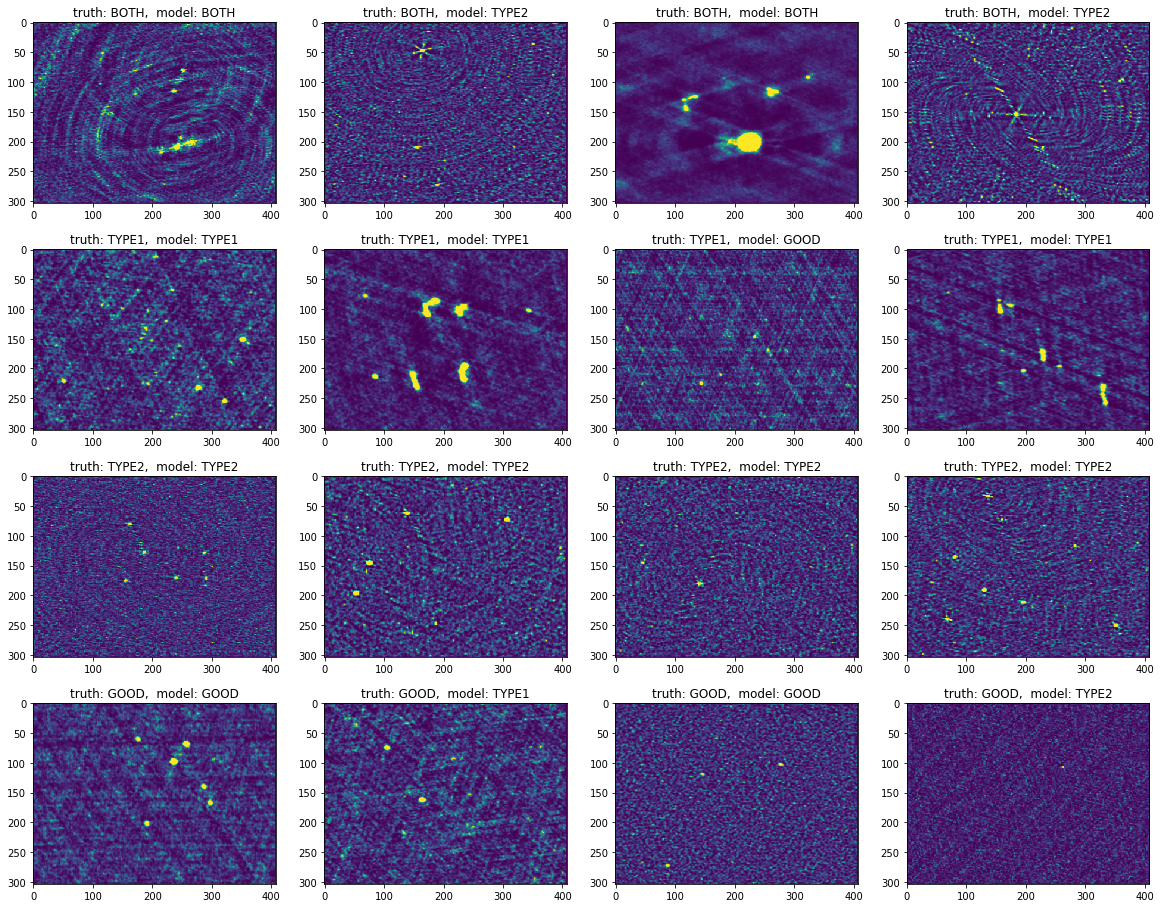

In [42]:
from matplotlib import colors
from sklearn.metrics import accuracy_score

# load best model saved during training
classifier = load_model('cnn_model2.h5')

preds = np.round(classifier.predict(dm[train]))
print('classifier accuracy on train set', accuracy_score(categories[train], preds))
print('weighted train accuracy', accuracy_score(categories[train], preds, sample_weight=sample_weights[train]))

preds = np.round(classifier.predict(dm[val]))
print('\nclassifier accuracy on val set', accuracy_score(categories[val], preds))
print('weighted val accuracy', accuracy_score(categories[val], preds, sample_weight=sample_weights[val]))

preds = np.round(classifier.predict(dm[test]))
print('\nclassifier accuracy on test set', accuracy_score(categories[test], preds))
print('weighted test accuracy', accuracy_score(categories[test], preds, sample_weight=sample_weights[test]))

# spot check some stuff
ff, aa = plt.subplots(4,4, figsize=(20,16))
labels = ['BOTH','TYPE1','TYPE2','GOOD']
samples = np.where(np.argmax(categories[test], axis=1) == 0)[0][:4]
for ii,ss in enumerate(samples):
  aa[0,ii].imshow(dm[test[ss]][:,:,0], norm=colors.PowerNorm(3))
  aa[0,ii].set_title('truth: BOTH,  model: ' + labels[np.argmax(preds[ss])])

samples = np.where(np.argmax(categories[test], axis=1) == 1)[0][:4]
for ii,ss in enumerate(samples):
  aa[1,ii].imshow(dm[test[ss]][:,:,0], norm=colors.PowerNorm(3))
  aa[1,ii].set_title('truth: TYPE1,  model: ' + labels[np.argmax(preds[ss])])

samples = np.where(np.argmax(categories[test], axis=1) == 2)[0][:4]
for ii,ss in enumerate(samples):
  aa[2,ii].imshow(dm[test[ss]][:,:,0], norm=colors.PowerNorm(3))
  aa[2,ii].set_title('truth: TYPE2,  model: ' + labels[np.argmax(preds[ss])])

samples = np.where(np.argmax(categories[test], axis=1) == 3)[0][:4]
for ii,ss in enumerate(samples):
  aa[3,ii].imshow(dm[test[ss]][:,:,0], norm=colors.PowerNorm(3))
  aa[3,ii].set_title('truth: GOOD,  model: ' + labels[np.argmax(preds[ss])])
